In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/CS331/

In [ ]:
%cd /content/drive/MyDrive/CS331/

/content/drive/MyDrive/CS331


In [ ]:
!wget https://s3-ap-northeast-1.amazonaws.com/leapmind-public-storage/datasets/camvid.tgz

--2022-06-21 14:15:38--  https://s3-ap-northeast-1.amazonaws.com/leapmind-public-storage/datasets/camvid.tgz
Resolving s3-ap-northeast-1.amazonaws.com (s3-ap-northeast-1.amazonaws.com)... 52.219.152.104
Connecting to s3-ap-northeast-1.amazonaws.com (s3-ap-northeast-1.amazonaws.com)|52.219.152.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186726299 (178M) [application/gzip]
Saving to: ‘camvid.tgz’

camvid.tgz          100%[===================>] 178.08M  26.7MB/s    in 7.7s    

2022-06-21 14:15:46 (23.1 MB/s) - ‘camvid.tgz’ saved [186726299/186726299]



In [ ]:
!tar -xzf camvid.tgz

In [ ]:
import os
import glob

In [ ]:
data_path = '/content/drive/MyDrive/CS331/CamVid/'

In [ ]:
train_img_paths = glob.glob(os.path.join(data_path, 'train/*'))
val_img_paths = glob.glob(os.path.join(data_path, 'val/*'))
test_img_paths = glob.glob(os.path.join(data_path, 'test/*'))

train_mask_paths = glob.glob(os.path.join(data_path, 'trainannot/*'))
val_mask_paths = glob.glob(os.path.join(data_path, 'valannot/*'))
test_mask_paths = glob.glob(os.path.join(data_path, 'testannot/*'))

print('Len train:', len(train_img_paths))
print('Len val:', len(val_img_paths))
print('Len test:', len(test_img_paths))

Len train: 367
Len val: 101
Len test: 233


In [ ]:
import torch.nn as nn
import cv2
import numpy as np
from tqdm import tqdm_notebook

In [ ]:
def normalize_negative_one(img):
    normalized_input = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
    return 2*normalized_input - 1

In [ ]:
# Load data
height, width, _ = 224, 224, 3
n_classes = 12

# Train
N_train = len(train_img_paths)
np_train_images = np.zeros((N_train, height, width, 3))
for idx, img_path in enumerate(train_img_paths):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (height, width))
    np_train_images[idx] = normalize_negative_one(image)

np_train_masks = np.zeros((N_train, height, width, n_classes))
for idx, mask_path in enumerate(train_mask_paths):
    mask = cv2.imread(mask_path, 1)
    mask = cv2.resize(mask, (height, width))[:,:,0]
    for c in range(n_classes):
        np_train_masks[idx][:, :, c] = (mask == c).astype(int)

# Val
N_val = len(val_img_paths)
np_val_images = np.zeros((N_val, height, width, 3))
for idx, img_path in enumerate(val_img_paths):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (height, width))
    np_val_images[idx] = normalize_negative_one(image)

np_val_masks = np.zeros((N_val, height, width, n_classes))
for idx, mask_path in enumerate(val_mask_paths):
    mask = cv2.imread(mask_path, 1)
    mask = cv2.resize(mask, (height, width))[:,:,0]
    for c in range(n_classes):
        np_val_masks[idx][:, :, c] = (mask == c).astype(int)

# Test
N_test = len(test_img_paths)
np_test_images = np.zeros((N_test, height, width, 3))
for idx, img_path in enumerate(test_img_paths):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (height, width))
    np_test_images[idx] = normalize_negative_one(image)

np_test_masks = np.zeros((N_test, height, width, n_classes))
for idx, mask_path in enumerate(test_mask_paths):
    mask = cv2.imread(mask_path, 1)
    mask = cv2.resize(mask, (height, width))[:,:,0]
    for c in range(n_classes):
        np_test_masks[idx][:, :, c] = (mask == c).astype(int)

In [ ]:
class FCN8s():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        return None
    
    def build(self):
        img_input = Input(shape=(224, 224, 3))

        # BOTTOM UP
        # Block 1
        x = Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv1')(img_input)
        x = Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv2')(x)
        pool1 = MaxPooling2D(pool_size = (2, 2), name = 'block1_pool')(x)

        # Block 2
        x = Conv2D(128, (3,3), activation='relu', padding='same', name='block2_conv1')(pool1)
        x = Conv2D(128, (3,3), activation='relu', padding='same', name='block2_conv2')(x)
        pool2 = MaxPooling2D(pool_size = (2, 2), name = 'block2_pool')(x)

        # Block 3
        x = Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv1')(pool2)
        x = Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv2')(x)
        x = Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv3')(x)
        pool3 = MaxPooling2D(pool_size = (2, 2), name = 'block3_pool')(x)

        # Block 4
        x = Conv2D(512, (3,3), activation='relu', padding='same', name='block4_conv1')(pool3)
        x = Conv2D(512, (3,3), activation='relu', padding='same', name='block4_conv2')(x)
        x = Conv2D(512, (3,3), activation='relu', padding='same', name='block4_conv3')(x)
        pool4 = MaxPooling2D(pool_size = (2, 2), name = 'block4_pool')(x)

        # Block 5
        x = Conv2D(512, (3,3), activation='relu', padding='same', name='block5_conv1')(pool4)
        x = Conv2D(512, (3,3), activation='relu', padding='same', name='block5_conv2')(x)
        x = Conv2D(512, (3,3), activation='relu', padding='same', name='block5_conv3')(x)
        pool5 = MaxPooling2D(pool_size = (2, 2), name = 'block5_pool')(x)

        # Conv6-7
        conv6 = Conv2D(4096, (7,7), activation='relu', padding='same', name='conv6')(pool5)
        conv6 = Dropout(0.1)(conv6)
        conv7 = Conv2D(4096, (1,1), activation='relu', padding='same', name='conv7')(conv6)
        conv7 = Dropout(0.1)(conv7)

        # TOP DOWN

        pool3 = Conv2D(self.num_classes, (1, 1))(pool3)
        pool4_2x = UpSampling2D(size=(2, 2))(pool4)
        pool4_2x = Conv2D(self.num_classes, (1, 1))(pool4_2x)
        conv7_4x = UpSampling2D(size=(4, 4))(conv7)
        conv7_4x = Conv2D(self.num_classes, (1, 1))(conv7_4x)

        output = Add()([pool3, pool4_2x, conv7_4x])
        output = UpSampling2D(size=(8, 8))(output)
        output = Conv2D(self.num_classes, (1, 1))(output)
        output = Softmax()(output)
        self.model = Model(inputs=img_input, outputs=output)
    
    def summary(self):
        self.model.summary()

## FCN32s - 16s - 8s

In [ ]:
from keras.layers import Conv2D, Input, MaxPooling2D, Conv2DTranspose, Dropout, Add, UpSampling2D, Softmax, Reshape, Activation, Concatenate
from keras import Model, losses, optimizers
import tensorflow as tf

In [ ]:
class FCN_backbone_VGG16():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.vgg16_model = tf.keras.applications.VGG16(
            include_top=False,
            weights='imagenet', input_tensor=Input(shape=(224, 224, 3))
        )

    def build_fcn32s(self):
        # img_input = Input(shape=(224, 224, 3))
        out = Conv2D(filters=4096, kernel_size = (7, 7), padding="same", activation="relu", name="fc6")(self.vgg16_model.output)
        out = Dropout(rate=0.5)(out)
        out = Conv2D(filters=4096, kernel_size = (1, 1), padding="same", activation="relu", name="fc7")(out)
        out = Dropout(rate=0.5)(out)
        out32s = Conv2D(filters=self.num_classes, kernel_size=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal", name="score_fr")(out)
        out = Conv2DTranspose(filters=self.num_classes, kernel_size=(32, 32), strides=(32, 32), padding="valid", activation=None, name="score2")(out32s)
        out = Reshape((-1, self.num_classes))(out)
        out = Activation("softmax")(out)
        
        fcn32s = Model(inputs=self.vgg16_model.input, outputs=out32s)
        self.model = Model(inputs=self.vgg16_model.input, outputs=out)
        return fcn32s
    
    def build_fcn16s(self):
        fcn32s = self.build_fcn32s()
        # 2x conv7 output
        out = Conv2DTranspose(filters=self.num_classes, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None, name="fcn32_upsamp2x")(fcn32s.output) # 28x28x12
        out = Conv2D(self.num_classes, kernel_size=(1,1), padding="same", activation='relu', name="score_fcn32_upsamp2x")(out)
        # score conv pool4 output
        pool4 = Conv2D(self.num_classes, kernel_size=(1,1), padding="same", activation='relu', name="score_pool4")(fcn32s.get_layer("block4_pool").output)
        # skip connection
        skip_conv1 = Add()([out, pool4])
        # score conv skip
        out16s = Conv2D(self.num_classes, kernel_size=(1,1), padding="same", activation='relu', name="score_skip_conv1")(skip_conv1)
        out = Conv2DTranspose(self.num_classes, kernel_size=(16, 16), strides=(16, 16), padding="valid", activation=None, name="output_fcn16s")(out16s)
        out = Reshape((-1, self.num_classes))(out)
        out = Activation("softmax")(out)

        fcn16s = Model(inputs=fcn32s.input, outputs=out16s)
        self.model = Model(inputs=fcn32s.input, outputs=out)
        return fcn16s

    def build_fcn8s(self):
        # build fcn16s truoc
        fcn16s = self.build_fcn16s()
        out = Conv2DTranspose(self.num_classes, kernel_size=(2, 2), strides=(2, 2), padding="valid", name="fcn16_upsamp2x", activation=None)(fcn16s.output)
        out = Conv2D(self.num_classes, kernel_size=(1,1), padding="same", activation='relu', name="score_fcn16_upsamp2x")(out)
        
        pool3 = Conv2D(self.num_classes, kernel_size=(1,1), padding="same", activation='relu', name="score_pool3")(fcn16s.get_layer("block3_pool").output)
        # skip connection
        skip_conv2 = Add()([out, pool3])
        # score conv skip
        out8s = Conv2D(self.num_classes, kernel_size=(1,1), activation='relu', padding="same", name="score_skip_conv2")(skip_conv2)
        out = Conv2DTranspose(self.num_classes, kernel_size=(8, 8), strides=(8, 8), padding="valid", activation=None, name="output_fcn8s")(out8s)
        out = Reshape((-1, self.num_classes))(out)
        out_final = Activation("softmax")(out)
        self.model = Model(inputs=fcn16s.input, outputs=out_final)

    def summary(self):
        self.model.summary()
    def complie(self, loss=None):
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
        self.model.compile(optimizer=optimizer, 
                           loss=losses.CategoricalCrossentropy())
    def fit(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        self.model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                       epochs=epochs, batch_size=batch_size)

In [ ]:
model = FCN_backbone_VGG16(num_classes=12)
model.build_fcn8s()
model.complie()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
np_train_masks_reshaped = np_train_masks.reshape(np_train_masks.shape[0], -1, 12)
np_val_masks_reshaped = np_val_masks.reshape(np_val_masks.shape[0], -1, 12)

In [ ]:
history = model.fit(X_train=np_train_images, y_train=np_train_masks_reshaped, \
                    X_val=np_val_images, y_val=np_val_masks_reshaped, epochs=100, batch_size=32)

## UNet

In [ ]:
class Unet_backbone_VGG16():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.vgg16_model = tf.keras.applications.VGG16(
            include_top=False,
            weights='imagenet', input_tensor=Input(shape=(224, 224, 3))
        )
        return None
    def build(self):
        backbone_network = self.vgg16_model
        conv6 = Conv2D(filters=512, kernel_size = (7, 7), padding="same", activation="relu", name="fc6")(backbone_network.output)
        conv6 = Dropout(rate=0.5)(conv6)
        conv7 = Conv2D(filters=1024, kernel_size = (1, 1), padding="same", activation="relu", name="fc7")(conv6)
        conv7 = Dropout(rate=0.5)(conv7)

        # Top-Down
        up6 = Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(4,4), padding="valid", activation=None, name="up6")(conv7)
        up6 = Conv2D(filters=512, kernel_size=(2,2), padding="same", activation='relu', name="conv1_up6")(up6)
        skipconnect6 = Concatenate(axis=-1)([up6, backbone_network.get_layer("block4_conv3").output])
        up6 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation='relu', name="conv2_up6")(skipconnect6)
        up6 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation='relu', name="conv3_up6")(up6)

        up7 = Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding="valid", activation=None, name="up7")(up6)
        up7 = Conv2D(filters=256, kernel_size=(2,2), padding="same", activation='relu', name="conv1_up7")(up7)
        skipconnect7 = Concatenate(axis=-1)([up7, backbone_network.get_layer("block3_conv3").output])
        up7 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2_up7")(skipconnect7)
        up7 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv3_up7")(up7)

        up8 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,2), padding="valid", activation=None, name="up8")(up7)
        up8 = Conv2D(filters=128, kernel_size=(2,2), padding="same", activation='relu', name="conv1_up8")(up8)
        skipconnect8 = Concatenate(axis=-1)([up8, backbone_network.get_layer("block2_conv2").output])
        up8 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv2_up8")(skipconnect8)
        up8 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv3_up8")(up8)

        up9 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding="valid", activation=None, name="up9")(up8)
        up9 = Conv2D(filters=64, kernel_size=(2,2), padding="same", activation='relu', name="conv1_up9")(up9)
        skipconnect9 = Concatenate(axis=-1)([up9, backbone_network.get_layer("block1_conv2").output])
        up9 = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name="conv2_up9")(skipconnect9)
        up9 = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name="conv3_up9")(up9)

        out = Conv2D(filters=self.num_classes, kernel_size=(1,1), padding="same", activation="relu", name="output")(up9)
        out = Reshape((-1, self.num_classes))(out)
        out = Activation("softmax")(out)

        self.model = Model(inputs=backbone_network.input, outputs=out)
    
    def complie(self, loss=None):
        optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
        self.model.compile(optimizer=optimizer, 
                           loss=losses.CategoricalCrossentropy())
    
    def summary(self):
        self.model.summary()

    def fit(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        self.model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                       epochs=epochs, batch_size=batch_size)

In [ ]:
model = Unet_backbone_VGG16(num_classes=12)
model.build()
model.complie()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
np_train_masks_reshaped = np_train_masks.reshape(np_train_masks.shape[0], -1, 12)
np_val_masks_reshaped = np_val_masks.reshape(np_val_masks.shape[0], -1, 12)

In [ ]:
history = model.fit(X_train=np_train_images, y_train=np_train_masks_reshaped, \
                    X_val=np_val_images, y_val=np_val_masks_reshaped, epochs=100, batch_size=32)

Epoch 1/100
12/12 [==============================] - 19s 1s/step - loss: 2.3854 - val_loss: 2.0998
Epoch 2/100
12/12 [==============================] - 9s 793ms/step - loss: 1.9425 - val_loss: 2.0169
Epoch 3/100
12/12 [==============================] - 10s 796ms/step - loss: 1.8760 - val_loss: 1.9340
Epoch 4/100
12/12 [==============================] - 10s 801ms/step - loss: 1.8388 - val_loss: 1.9138
Epoch 5/100
12/12 [==============================] - 10s 796ms/step - loss: 1.8120 - val_loss: 1.8811
Epoch 6/100
12/12 [==============================] - 10s 798ms/step - loss: 1.7909 - val_loss: 1.8639
Epoch 7/100
12/12 [==============================] - 9s 792ms/step - loss: 1.7748 - val_loss: 1.8454
Epoch 8/100
12/12 [==============================] - 9s 792ms/step - loss: 1.7606 - val_loss: 1.8332
Epoch 9/100
12/12 [==============================] - 10s 797ms/step - loss: 1.7478 - val_loss: 1.8402
Epoch 10/100
12/12 [==============================] - 10s 796ms/step - loss: 1.7380 - va

In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


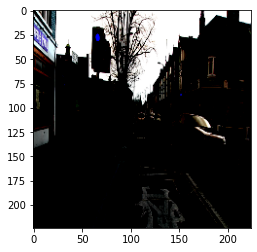

In [ ]:
plt.imshow(np_test_images[102])

In [ ]:
prediction = model.model.predict(np_test_images[102].reshape(1, 224, 224, 3))

In [ ]:
final_prediction = np.argmax(prediction.reshape(1, 224, 224, 12), -1)

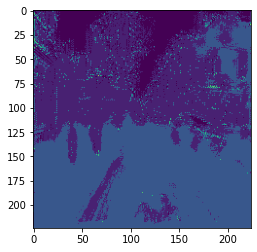

In [ ]:
plt.imshow(final_prediction[0])

In [ ]:
final_prediction

array([[[1, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 5, 0, ..., 0, 0, 1],
        ...,
        [1, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]]])